# Project-1-Spotify

We are a consulting company for independent artists. We are helping a new Mexican artist to launch their next hit in Mexico and Latin America, which is planned to be released in last quarter 2020 in the Spotify platform, to remain in the Top 50 Chart throughout the next year.

Tasks:

* Identify most popular music genres in the population segment that the artist is targeting.
* Identify patterns in the tempo, energy, danceability and acousticness of the music that people in that segment listen to in different quarters.
* Define the properties that the artist's song should have to be succesful in last quarter 2020 in Mexico and Latin America.
* Predict how popular this song will be in upcoming quarters.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

analysis=pd.read_excel("complete_dfr.xlsx")
analysis

,Unnamed: 0,Position,Track Name,Artist,URL_x,Date,id_x,url,danceability,energy,...,valence,tempo,type,id_y,uri,track_href,analysis_url,duration_ms,time_signature,Position_I
0,0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,https://open.spotify.com/track/0mb7btREdC3wuIU...,2017-01-01,0mb7btREdC3wuIUmuVRgWn,https://api.spotify.com/v1/audio-features?ids=...,0.579,0.904,...,0.713,175.316,audio_features,0mb7btREdC3wuIUmuVRgWn,spotify:track:0mb7btREdC3wuIUmuVRgWn,NaN,NaN,187853,4,-1
1,1,2,El Año Viejo,Tony Camargo,https://open.spotify.com/track/6NjhADkaWwGYO0R...,2017-01-01,6NjhADkaWwGYO0R7eZXyI4,https://api.spotify.com/v1/audio-features?ids=...,0.740,0.521,...,0.904,159.694,audio_features,6NjhADkaWwGYO0R7eZXyI4,spotify:track:6NjhADkaWwGYO0R7eZXyI4,NaN,NaN,182720,4,-2
2,2,3,La Edad de los Países,Hernán Casciari,https://open.spotify.com/track/5gA5Tvu7zlihzqU...,2017-01-01,5gA5Tvu7zlihzqUvmPUqoi,https://api.spotify.com/v1/audio-features?ids=...,0.606,0.301,...,0.941,62.876,audio_features,5gA5Tvu7zlihzqUvmPUqoi,spotify:track:5gA5Tvu7zlihzqUvmPUqoi,NaN,NaN,280521,3,-3
3,3,4,"Shake It Off - From ""Sing"" Original Motion Pic...",Nick Kroll,https://open.spotify.com/track/2Q0WZoJaRJlelcx...,2017-01-01,2Q0WZoJaRJlelcxqOvowUc,https://api.spotify.com/v1/audio-features?ids=...,0.738,0.906,...,0.831,160.088,audio_features,2Q0WZoJaRJlelcxqOvowUc,spotify:track:2Q0WZoJaRJlelcxqOvowUc,NaN,NaN,120560,4,-4
4,4,5,Another Day Of Sun,La La Land Cast,https://open.spotify.com/track/5kRBzRZmZTXVg8o...,2017-01-01,5kRBzRZmZTXVg8okC7SJFZ,https://api.spotify.com/v1/audio-features?ids=...,0.588,0.742,...,0.824,125.819,audio_features,5kRBzRZmZTXVg8okC7SJFZ,spotify:track:5kRBzRZmZTXVg8okC7SJFZ,NaN,NaN,228173,4,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58845,58845,46,Amor Tumbado,Natanael Cano,https://open.spotify.com/track/5aJ1M43pinROpwa...,2020-03-30,5aJ1M43pinROpwaPnO8KRj,NaN,0.535,0.714,...,0.458,100.059,audio_features,5aJ1M43pinROpwaPnO8KRj,spotify:track:5aJ1M43pinROpwaPnO8KRj,NaN,NaN,221554,3,-46
58846,58846,47,Yo Ya No Vuelvo Contigo - En Vivo,Lenin Ramírez,https://open.spotify.com/track/1s59X35jDULAyOG...,2020-03-30,1s59X35jDULAyOGmBuTAnd,NaN,0.644,0.350,...,0.541,118.206,audio_features,1s59X35jDULAyOGmBuTAnd,spotify:track:1s59X35jDULAyOGmBuTAnd,NaN,NaN,240457,1,-47
58847,58847,48,CITY OF ANGELS,24kGoldn,https://open.spotify.com/track/6ap9lSRJ0iLriGL...,2020-03-30,6ap9lSRJ0iLriGLqoJ44cq,NaN,0.686,0.541,...,0.724,120.084,audio_features,6ap9lSRJ0iLriGLqoJ44cq,spotify:track:6ap9lSRJ0iLriGLqoJ44cq,NaN,NaN,112493,4,-48
58848,58848,49,Savage,Megan Thee Stallion,https://open.spotify.com/track/55CHeLEfn5iJ0II...,2020-03-30,55CHeLEfn5iJ0IIkgaa4si,NaN,0.843,0.741,...,0.680,168.983,audio_features,55CHeLEfn5iJ0IIkgaa4si,spotify:track:55CHeLEfn5iJ0IIkgaa4si,NaN,NaN,155497,4,-49


In [2]:
#Limpieza de datos para quitar la columna Unnamed:0
analysis=analysis.drop(['Unnamed: 0'], axis=1)
analysis.head()

,Position,Track Name,Artist,URL_x,Date,id_x,url,danceability,energy,key,...,valence,tempo,type,id_y,uri,track_href,analysis_url,duration_ms,time_signature,Position_I
0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,https://open.spotify.com/track/0mb7btREdC3wuIU...,2017-01-01,0mb7btREdC3wuIUmuVRgWn,https://api.spotify.com/v1/audio-features?ids=...,0.579,0.904,10,...,0.713,175.316,audio_features,0mb7btREdC3wuIUmuVRgWn,spotify:track:0mb7btREdC3wuIUmuVRgWn,NaN,NaN,187853,4,-1
1,2,El Año Viejo,Tony Camargo,https://open.spotify.com/track/6NjhADkaWwGYO0R...,2017-01-01,6NjhADkaWwGYO0R7eZXyI4,https://api.spotify.com/v1/audio-features?ids=...,0.740,0.521,0,...,0.904,159.694,audio_features,6NjhADkaWwGYO0R7eZXyI4,spotify:track:6NjhADkaWwGYO0R7eZXyI4,NaN,NaN,182720,4,-2
2,3,La Edad de los Países,Hernán Casciari,https://open.spotify.com/track/5gA5Tvu7zlihzqU...,2017-01-01,5gA5Tvu7zlihzqUvmPUqoi,https://api.spotify.com/v1/audio-features?ids=...,0.606,0.301,9,...,0.941,62.876,audio_features,5gA5Tvu7zlihzqUvmPUqoi,spotify:track:5gA5Tvu7zlihzqUvmPUqoi,NaN,NaN,280521,3,-3
3,4,"Shake It Off - From ""Sing"" Original Motion Pic...",Nick Kroll,https://open.spotify.com/track/2Q0WZoJaRJlelcx...,2017-01-01,2Q0WZoJaRJlelcxqOvowUc,https://api.spotify.com/v1/audio-features?ids=...,0.738,0.906,11,...,0.831,160.088,audio_features,2Q0WZoJaRJlelcxqOvowUc,spotify:track:2Q0WZoJaRJlelcxqOvowUc,NaN,NaN,120560,4,-4
4,5,Another Day Of Sun,La La Land Cast,https://open.spotify.com/track/5kRBzRZmZTXVg8o...,2017-01-01,5kRBzRZmZTXVg8okC7SJFZ,https://api.spotify.com/v1/audio-features?ids=...,0.588,0.742,8,...,0.824,125.819,audio_features,5kRBzRZmZTXVg8okC7SJFZ,spotify:track:5kRBzRZmZTXVg8okC7SJFZ,NaN,NaN,228173,4,-5


In [8]:
counta=analysis.groupby(['Artist','Track Name']).size()
count2019=analysis[(analysis['Date']>'2018-12-31') & (analysis['Date']<'2020-01-01')]
count2019=count2019.groupby(['Artist','Track Name']).size().reset_index(name="Number of days in Top 50 Chart")
count2019


,Artist,Track Name,Number of days in Top 50 Chart
0,21 Savage,a lot,27
1,4 Elementos,Cypher #1 (Reggae Cypher),29
2,5 Seconds of Summer,Lie To Me (feat. Julia Michaels),5
3,6ix9ine,MALA (feat. Anuel Aa),16
4,A Boogie Wit da Hoodie,Look Back At It,19
...,...,...,...
794,benny blanco,"I Can’t Get Enough (benny blanco, Selena Gomez...",21
795,blackbear,hot girl bummer,9
796,deadman 死人,Omae Wa Mou,13
797,j-hope,Chicken Noodle Soup (feat. Becky G),9


#### My first analysis was to observe the life of a song on the Hit Parade. At a first instance to the data I came to know that there was a particular song that had been for more than a year on the list.
#### So, a Boxplot Analysis would let me observe if the song is an outlier and found this

In [9]:
#Cuenta cuantas veces aparece la canción en el Top 50 de Spotify
count=analysis.groupby(['Artist','Track Name']).size().reset_index(name="Number of days in Top 50 Chart")
count.head()

,Artist,Track Name,Number of days in Top 50 Chart
0,( Me Llamo ) Sebastián,Baila como hombre,23
1,(G)I-DLE,LATATA,12
2,21 Savage,Bank Account,3
3,21 Savage,a lot,27
4,24kGoldn,CITY OF ANGELS,23


In [10]:
lista = count2019["Number of days in Top 50 Chart"].tolist()

In [13]:
# figure related code
fig = plt.figure()
fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)

ax.set_title('axes title')
ax.set_xlabel('xlabel')
ax.set_ylabel('ylabel')
plt.boxplot(lista, showmeans=True)
plt.grid()
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

In [14]:
countl=count2019['Number of days in Top 50 Chart']
quartiles =countl.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
average=count2019['Number of days in Top 50 Chart'].mean()

print(f"The lower quartile life of a song in Top 50 chart is: {lowerq}")
print(f"The upper quartile life of a songs in Top 50 chart is: {upperq}")
print(f"The interquartile range life of a song in Top 50 chart is: {iqr}")
print(f"The the median life of a song in Top 50 is: {quartiles[0.5]} ")

print(f"The average life of a song in Top 50 in 2019 is: {average}")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile life of a song in Top 50 chart is: 6.0
The upper quartile life of a songs in Top 50 chart is: 26.0
The interquartile range life of a song in Top 50 chart is: 20.0
The the median life of a song in Top 50 is: 12.0 
The average life of a song in Top 50 in 2019 is: 22.425531914893618
Values below -24.0 could be outliers.
Values above 56.0 could be outliers.


In [15]:
#Resumen por Artista, Fecha y Canción con las caracterìsticas de la canciòn
chart=analysis.groupby(['Artist','Date', 'Track Name','Position']).mean()
chart

danceability  \
Artist                 Date       Track Name        Position                 
( Me Llamo ) Sebastián 2017-08-14 Baila como hombre 1                0.711   
                       2017-08-15 Baila como hombre 1                0.711   
                       2017-08-16 Baila como hombre 2                0.711   
                       2017-08-17 Baila como hombre 1                0.711   
                       2017-08-18 Baila como hombre 1                0.711   
...                                                                    ...   
マジカル・クラウズ              2017-01-20 Downtown          15               0.372   
                       2017-01-21 Downtown          24               0.372   
                       2017-01-22 Downtown          21               0.372   
                       2017-01-24 Downtown          42               0.372   
                       2017-01-25 Downtown          37               0.372   

                                                              energy  key  \
Artist                 Date       Track Name        Position                
( Me Llamo ) Sebastián 2017-08-14 Baila como hombre 1          0.528    9   
                       2017-08-15 Baila como hombre 1          0.528    9   
                       2017-08-16 Baila como hombre 2          0.528    9   
                       2017-08-17 Baila como hombre 1          0.528    9   
                       2017-08-18 Baila como hombre 1          0.528    9   
...                                                              ...  ...   
マジカル・クラウズ              2017-01-20 Downtown          15         0.262    6   
                       2017-01-21 Downtown          24         0.262    6   
                       2017-01-22 Downtown          21         0.262    6   
                       2017-01-24 Downtown          42         0.262    6   
                       2017-01-25 Downtown          37         0.262    6   

                                                              loudness  mode  \
Artist                 Date       Track Name        Position                   
( Me Llamo ) Sebastián 2017-08-14 Baila como hombre 1           -7.341     0   
                       2017-08-15 Baila como hombre 1           -7.341     0   
                       2017-08-16 Baila como hombre 2           -7.341     0   
                       2017-08-17 Baila como hombre 1           -7.341     0   
                       2017-08-18 Baila como hombre 1           -7.341     0   
...                                                                ...   ...   
マジカル・クラウズ              2017-01-20 Downtown          15          -9.030     1   
                       2017-01-21 Downtown          24          -9.030     1   
                       2017-01-22 Downtown          21          -9.030     1   
                       2017-01-24 Downtown          42          -9.030     1   
                       2017-01-25 Downtown          37          -9.030     1   

                                                              speechiness  \
Artist                 Date       Track Name        Position                
( Me Llamo ) Sebastián 2017-08-14 Baila como hombre 1              0.0408   
                       2017-08-15 Baila como hombre 1              0.0408   
                       2017-08-16 Baila como hombre 2              0.0408   
                       2017-08-17 Baila como hombre 1              0.0408   
                       2017-08-18 Baila como hombre 1              0.0408   
...                                                                   ...   
マジカル・クラウズ              2017-01-20 Downtown          15             0.0290   
                       2017-01-21 Downtown          24             0.0290   
                       2017-01-22 Downtown          21             0.0290   
                       2017-01-24 Downtown          42             0.0290   
                       2017-01-25 Downtown          37             0.0290   

  

In [47]:
filet1=graph2019[(graph2019['Artist']=='Kim Loaiza') & (graph2019['Track Name']=='Amándote')]
filet2=graph2019[(graph2019['Artist']=='Julión Álvarez & Su Norteño Banda') & (graph2019['Track Name']=='Más Te Recuerdo')]
filet3=graph2019[(graph2019['Artist']=='Harry Styles') & (graph2019['Track Name']=='Watermelon Sugar')]
filet4=graph2019[(graph2019['Artist']=='Mamamoo') & (graph2019['Track Name']=='HIP')]
y1=filet1['Position_I']
y2=filet2['Position_I']
y3=filet3['Position_I']
y4=filet4['Position_I']
x=filet1['Date']

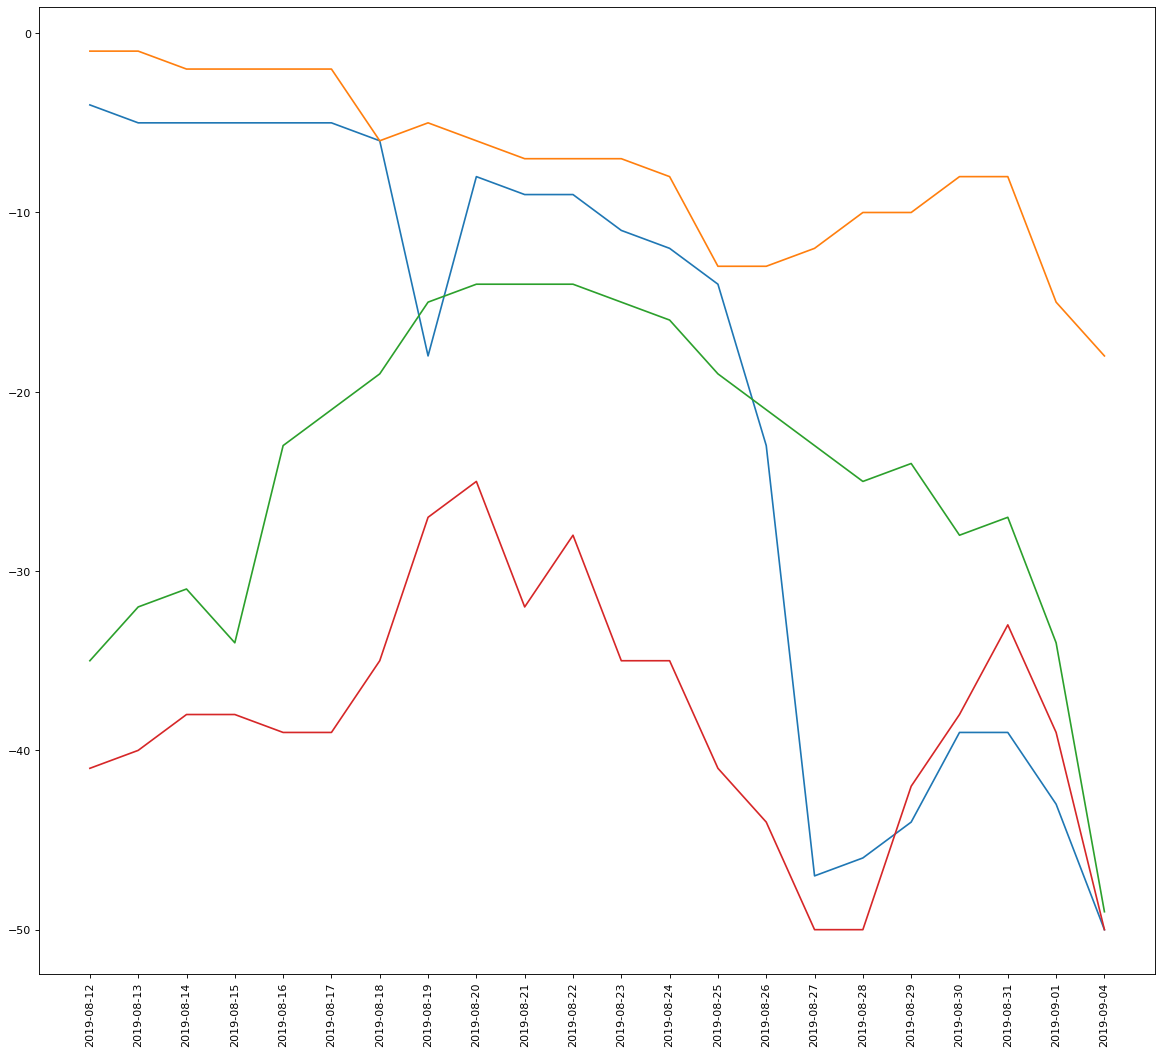

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#For all Matplotlib plots, we start by creating a figure and an axes. In their simplest form, a figure 
#and axes can be created as follows:

fig=plt.figure(figsize=(18, 16), dpi= 80) #, facecolor='w', edgecolor='k')
ax = plt.axes()

x.astype('datetime64[ns]')

plt.xticks(rotation=90)

plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)

In [21]:
filet_by_4q2017=analysis[(analysis['Date']>'2017-09-30') & (analysis['Date']<'2018-01-01')]
filet_by_4q2018=analysis[(analysis['Date']>'2018-09-30') & (analysis['Date']<'2019-01-01')]
filet_by_4q2019=analysis[(analysis['Date']>'2019-09-30') & (analysis['Date']<'2020-01-01')]

In [22]:
count02=filet_by_4q2017.groupby(['Artist','Track Name']).size()
count02.to_excel("count02.xlsx")

In [23]:
count03=filet_by_4q2018.groupby(['Artist','Track Name']).size()
count03.to_excel("count03.xlsx")

In [13]:
count04=filet_by_4q2019.groupby(['Artist','Track Name']).size()
count04

Artist                Track Name                         
Abraham Mateo         ¿Qué Ha Pasao'?                         3
Adriana Ledesma Ross  Tumbas por Aquí                        11
Adriel Favela         Asi toco mi Vida                        2
Alejandro Fernandez   Caballero                              40
Anita y los Peleles   El Twist del Esqueleto                  2
                                                             ..
Yera                  Mejores Amigos                         24
Yuri                  Una Mentira Más                         1
Yuridia               No Le Llames Amor                       3
blackbear             hot girl bummer                         8
j-hope                Chicken Noodle Soup (feat. Becky G)     9
Length: 242, dtype: int64

In [14]:
filet_by_2q2017=analysis[(analysis['Date']>'2017-03-31') & (analysis['Date']<'2017-07-01')]
filet_by_2q2018=analysis[(analysis['Date']>'2018-03-31') & (analysis['Date']<'2018-07-01')]
filet_by_2q2019=analysis[(analysis['Date']>'2019-03-31') & (analysis['Date']<'2019-07-01')]

In [15]:
count05=filet_by_2q2017.groupby(['Artist','Track Name']).size()
count06=filet_by_2q2018.groupby(['Artist','Track Name']).size()
count07=filet_by_2q2019.groupby(['Artist','Track Name']).size()

In [16]:
filet_by_1q2017=analysis[(analysis['Date']>'2016-12-31') & (analysis['Date']<'2017-04-01')]
filet_by_1q2018=analysis[(analysis['Date']>'2017-12-31') & (analysis['Date']<'2018-04-01')]
filet_by_1q2019=analysis[(analysis['Date']>'2018-12-31') & (analysis['Date']<'2019-04-01')]
filet_by_1q2020=analysis[(analysis['Date']>'2019-12-31') & (analysis['Date']<'2020-04-01')]

In [17]:
count08=filet_by_1q2017.groupby(['Artist','Track Name']).size()
count09=filet_by_1q2018.groupby(['Artist','Track Name']).size()
count10=filet_by_1q2019.groupby(['Artist','Track Name']).size()
count11=filet_by_1q2020.groupby(['Artist','Track Name']).size()

In [25]:
filet_by_3q2017=analysis[(analysis['Date']>'2017-06-30') & (analysis['Date']<'2017-10-01')]
filet_by_3q2018=analysis[(analysis['Date']>'2018-06-30') & (analysis['Date']<'2018-10-01')]
filet_by_3q2019=analysis[(analysis['Date']>'2019-06-30') & (analysis['Date']<'2019-10-01')]

In [27]:
count12=filet_by_3q2017.groupby(['Artist','Track Name']).size()
count13=filet_by_3q2018.groupby(['Artist','Track Name']).size()
count14=filet_by_3q2019.groupby(['Artist','Track Name']).size()

In [28]:
count12.to_excel("count12.xlsx")
count13.to_excel("count13.xlsx")
count14.to_excel("count14.xlsx")

## Hypothesis: If we determine the optimal mix of the variables related to a successful song in Mexico, then we can help the artist release a successful song in the last quarter of 2020:

## If the tempo of a song is higher than 100 bpm, then it will be more popular.

## If the chooses to release a reggaeton song, then it will remain in the Top 50 Chart throughout the next year.

## If a song has a higher level of energy, then it will be more likely to be in the Top 50 throughout the next year.

## If a song has a higher level of danceability, then it will be more likely to be in the Top 50 throughout the next year.

Text(0, 0.5, 'Score')

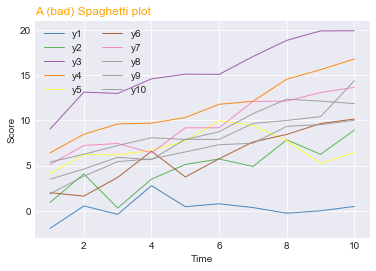

In [31]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21), 'y4': np.random.randn(10)+range(6,16), 'y5': np.random.randn(10)+range(4,14)+(0,0,0,0,0,0,0,-3,-8,-6), 'y6': np.random.randn(10)+range(2,12), 'y7': np.random.randn(10)+range(5,15), 'y8': np.random.randn(10)+range(4,14), 'y9': np.random.randn(10)+range(4,14), 'y10': np.random.randn(10)+range(2,12) })
 
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num=num+1
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
 
# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Score")
